In [ ]:
'''
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip /content/*zip -d '/content/drive/Shareddrives/Colab Stuff/Dataset'
'''

"\nimport os\nos.environ['KAGGLE_CONFIG_DIR'] = '/content'\n!kaggle datasets download -d tawsifurrahman/covid19-radiography-database\n!unzip /content/*zip -d '/content/drive/Shareddrives/Colab Stuff/Dataset'\n"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

from collections import Counter

In [ ]:
#Setting up the data
img_path = '/content/drive/Shareddrives/Colab Stuff/Dataset/COVID-19_Radiography_Dataset/'
list_files = []
for dir in os.listdir(img_path):
    aux_dir = os.path.join(img_path,dir)
    
    if os.path.isdir(aux_dir):
        for img in os.listdir(aux_dir):
            list_files.append([os.path.join(dir,img),dir])

df = pd.DataFrame(list_files, columns=['Image id', 'Label'])
df

,Image id,Label
0,COVID/COVID-3327.png,COVID
1,COVID/COVID-336.png,COVID
2,COVID/COVID-3333.png,COVID
3,COVID/COVID-3354.png,COVID
4,COVID/COVID-3331.png,COVID
...,...,...
21160,Viral Pneumonia/Viral Pneumonia-1311.png,Viral Pneumonia
21161,Viral Pneumonia/Viral Pneumonia-1307.png,Viral Pneumonia
21162,Viral Pneumonia/Viral Pneumonia-1296.png,Viral Pneumonia
21163,Viral Pneumonia/Viral Pneumonia-1298.png,Viral Pneumonia


In [ ]:
#Function to view number of images for each label
def data_vis(df):
    num = pd.DataFrame.from_dict(Counter(df.Label), orient = 'index').reset_index()
    num.columns = ['Label', 'Number']
    return num

data_vis(df)

,Label,Number
0,COVID,3616
1,Lung_Opacity,6012
2,Normal,10192
3,Viral Pneumonia,1345


In [ ]:
#Undersampling Normal Class
df.Label.unique()
df_cov = df[df.Label == 'COVID']
df_norm = df[df.Label == 'Normal']

df_norm = df_norm[:4500]
df_final = pd.concat((df_norm, df_cov), axis = 0)

data_vis(df_final)

,Label,Number
0,Normal,4500
1,COVID,3616


In [ ]:
#df_final['Image id'] = img_path + df_final['Image id']

## Pre-Processing

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import to_categorical as to

In [ ]:
#Splitting the dataset
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=69)
#df_final = df_final.reset_index()
for train_index, test_index in sss.split(df_final['Image id'], df_final['Label']):
    x_train, x_test = df_final['Image id'].to_numpy()[train_index], df_final['Image id'].to_numpy()[test_index]
    y_train, y_test = df_final['Label'].to_numpy()[train_index], df_final['Label'].to_numpy()[test_index]


traindf = pd.concat([pd.DataFrame(x_train, columns=['Image id']), pd.DataFrame(y_train, columns=['Label'])], axis=1)
testdf = pd.concat([pd.DataFrame(x_test, columns=['Image id']), pd.DataFrame(y_test, columns=['Label'])], axis=1)

traindf['Image id'] = img_path + traindf['Image id']
testdf['Image id'] = img_path + testdf['Image id']


In [ ]:
testdf['Image id'][1]

'/content/drive/Shareddrives/Colab Stuff/Dataset/COVID-19_Radiography_Dataset/Normal/Normal-7188.png'

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1/255.0, validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1/255.0)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe = traindf, 
                                            x_col = 'Image id', 
                                            y_col = 'Label', 
                                            shuffle = True, 
                                            subset = 'training',
                                            interpolation = 'nearest',
                                            batch_size = 128, 
                                            class_mode = 'categorical', 
                                            color_mode = 'grayscale',
                                            seed = 420,
                                            target_size = (224,224))

val_generator = train_datagen.flow_from_dataframe(dataframe = traindf, 
                                            x_col = 'Image id', 
                                            y_col = 'Label', 
                                            shuffle = True, 
                                            subset = 'validation',
                                            interpolation = 'nearest',
                                            batch_size = 32, 
                                            class_mode = 'categorical', 
                                            color_mode = 'grayscale',
                                            seed = 420,
                                            target_size = (224,224))

test_generator = test_datagen.flow_from_dataframe(dataframe = testdf, 
                                            x_col = 'Image id', 
                                            y_col = 'Label', 
                                            shuffle = True, 
                                            subset = 'validation',
                                            interpolation = 'nearest',
                                            batch_size = 32, 
                                            class_mode = 'categorical', 
                                            color_mode = 'grayscale',
                                            seed = 420,
                                            target_size = (224,224))

Found 4545 validated image filenames belonging to 2 classes.
Found 1136 validated image filenames belonging to 2 classes.
Found 0 validated image filenames belonging to 2 classes.


In [ ]:
print(train_generator.class_indices, val_generator.class_indices)

{'COVID': 0, 'Normal': 1} {'COVID': 0, 'Normal': 1}


In [ ]:
train_generator.image_shape

(224, 224, 1)

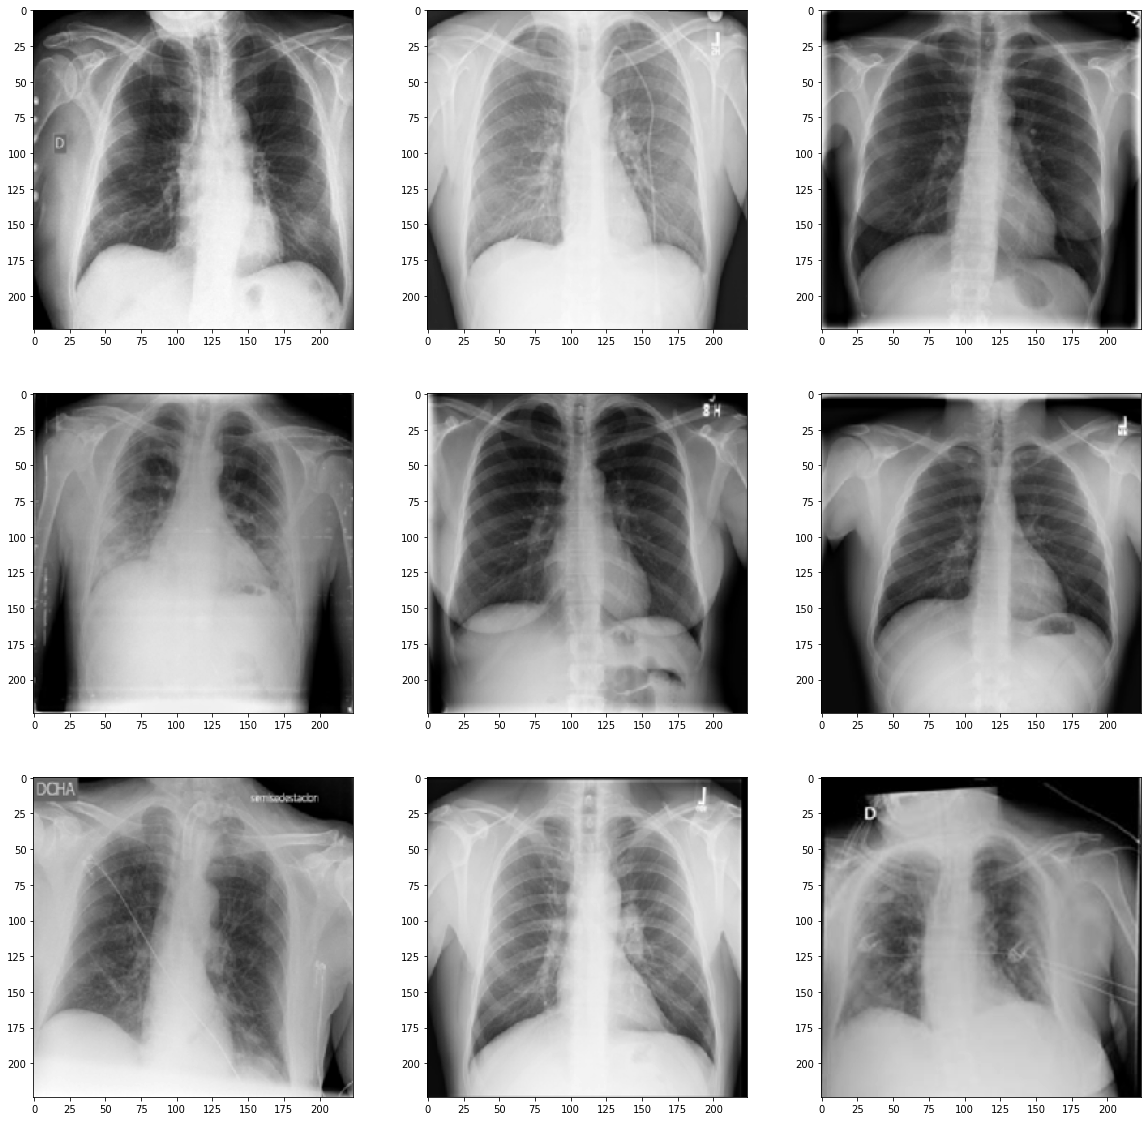

In [ ]:
#for rotation
plt.figure(figsize = (20,20))
for i in range(9):
    plt.subplot(330+1+i)
    plt.imshow(train_generator[0][0][i].reshape(224,224), cmap = 'gray')
plt.show()

## The Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy, BinaryCrossentropy
from keras.optimizers import Adam, SGD
import keras.backend as k
from tqdm.keras import TqdmCallback
from keras.callbacks import EarlyStopping, LearningRateScheduler

In [ ]:
k.clear_session()

In [ ]:
#model.save('/content/model1train2.h5')

In [ ]:
import math
def append_history(m1, m2):
    m1.history['accuracy'] = np.append(m1.history['accuracy'], m2.history['accuracy'])
    m1.history['val_accuracy'] = np.append(m1.history['val_accuracy'], m2.history['val_accuracy'])
    m1.history['loss'] = np.append(m1.history['loss'], m2.history['loss'])
    m1.history['val_loss'] = np.append(m1.history['val_loss'], m2.history['val_loss'])

    return m1    

def step_decay(epoch):
   initial_lrate = 0.0001
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

lrate = LearningRateScheduler(step_decay)
es_callback = EarlyStopping(monitor = 'val_loss', patience = 5)

opt = SGD(learning_rate = 0.001)

In [ ]:
model = Sequential([
                    Conv2D(96, (7, 7), activation = 'relu', strides = (4, 4), input_shape = (224,224,1)),
                    MaxPool2D((3, 3), strides = (2, 2)),
                    Dropout(0.5),
                    Conv2D(128, (5, 5), activation = 'relu', strides = (1, 1), padding = 'same'),
                    BatchNormalization(),
                    Conv2D(128, (5, 5), activation = 'relu', strides = (1, 1), padding = 'same'),
                    MaxPool2D((3, 3), strides = (2, 2)),
                    Dropout(0.3),
                    Flatten(),
                    Dense(512, activation = 'relu'),
                    Dropout(0.5),
                    Dense(256, activation = 'relu'),
                    Dense(32, activation = 'relu'),
                    Dense(2, activation = 'softmax')
])

model.compile(optimizer = opt, loss = CategoricalCrossentropy(), metrics = ['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = 250,
                    shuffle = True,
                    steps_per_epoch = 20,
                    validation_steps = 15,
                    verbose = 0,
                    callbacks = [TqdmCallback(verbose=1), lrate, es_callback]
)

In [ ]:
history1 = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = 50,
                    shuffle = True,
                    max_queue_size = 100,
                    verbose = 0,
                    callbacks = [TqdmCallback(verbose=1), lrate]
)

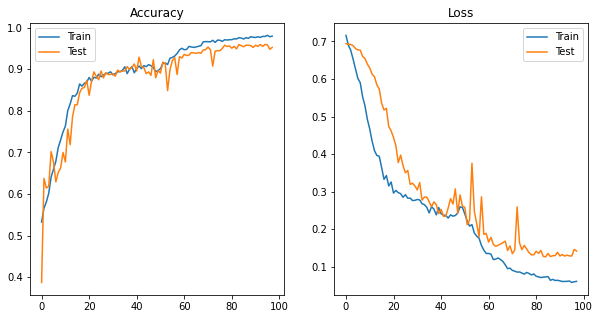

In [ ]:
history = append_history(history, history1)

#Plots
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title("Accuracy")
plt.legend()

plt.subplot(122)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title("Loss")
plt.legend()

plt.show()

NameError: ignored

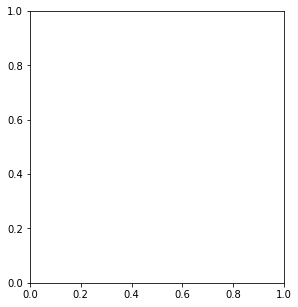

In [ ]:
#history = append_history(history, history1)

#Plots
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title("Accuracy")
plt.legend()

plt.subplot(122)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title("Loss")
plt.legend()

plt.show()

In [ ]:
img_test = cv.imread('/content/drive/Shareddrives/Colab Stuff/Dataset/COVID-19_Radiography_Dataset/COVID/COVID-1.png')

In [ ]:
img_test = img_test.reshape(1,299,299,3)

In [ ]:
model.predict(img_test)

array([[0.]], dtype=float32)

## Load and retrain

In [ ]:
from keras.models import load_model
model2 = load_model('/content/drive/Shareddrives/Colab Stuff/Covid19/New gen/model.h5')
model3 = load_model('/content/drive/Shareddrives/Colab Stuff/Covid19/New gen/model.h5')

In [ ]:
def remove_last_n_and_freeze(model, n, freeze = bool):
    for i in range(n):
        model.pop()
    if (bool):
        for i in range(len(model.layers)):
            model.layers[i].trainable = False

In [ ]:
model2.layers

In [ ]:
remove_last_n_and_freeze(model2, 4, freeze = True)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 55, 55, 96)        4800      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 128)       307328    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 27, 128)       409728    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 13, 128)      

In [ ]:
model2.add(Dense(1024, activation = 'relu', name = 'add1'))
model2.add(Dropout(0.3, name = 'add2'))
model2.add(Dense(512, activation = 'relu', name = 'add3'))
model2.add(Dropout(0.3, name = 'add4'))
model2.add(Dense(256, activation = 'relu', name = 'add5'))
model2.add(Dropout(0.5, name = 'add6'))
model2.add(Dense(32, activation = 'relu', name = 'add7'))
model2.add(Dense(1, activation = 'sigmoid', name = 'output'))            

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 55, 55, 96)        4800      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 128)       307328    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 27, 128)       409728    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 13, 128)      

In [ ]:
datagen2 = ImageDataGenerator(rescale = 1/255.0, validation_split = 0.2)
train_generator2 = datagen.flow_from_dataframe(dataframe = df_final, 
                                            x_col = 'Image id', 
                                            y_col = 'Label', 
                                            shuffle = True, 
                                            subset = 'training',
                                            interpolation = 'nearest',
                                            batch_size = 64, 
                                            class_mode = 'binary', 
                                            color_mode = 'grayscale',
                                            seed = 420,
                                            target_size = (224,224))

val_generator2 = datagen.flow_from_dataframe(dataframe = df_final, 
                                            x_col = 'Image id', 
                                            y_col = 'Label', 
                                            shuffle = True, 
                                            subset = 'validation',
                                            interpolation = 'nearest',
                                            batch_size = 32, 
                                            class_mode = 'binary', 
                                            color_mode = 'grayscale',
                                            seed = 420,
                                            target_size = (224,224))

Found 6093 validated image filenames belonging to 2 classes.
Found 1523 validated image filenames belonging to 2 classes.


In [ ]:
history3=model2.fit(train_generator2,
                    validation_data = val_generator2,
                    epochs = 50,
                    shuffle = True,
                    #max_queue_size = 100,
                    #steps_per_epoch = 20,
                    #validation_steps = 20,
                    verbose = 0,
                    callbacks = [TqdmCallback(verbose=1), lrate])

KeyboardInterrupt: ignored

In [ ]:
history2 = append_history(history2, history3)
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Test')
plt.title("Accuracy")
plt.legend()

plt.subplot(122)
plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='Test')
plt.title("Loss")
plt.legend()

plt.show()

In [ ]:
model2.evaluate(val_generator2)

In [ ]:
test = load_model('/content/drive/Shareddrives/Colab Stuff/Covid19/Models/set2_v7.h5')

In [ ]:
img_test.shape

(1, 299, 299, 3)

In [ ]:
img_test_dim1 = img_test[:][:][:][:]

In [ ]:
img_test_dim1.shape

(1, 299, 299, 3)

In [ ]:
img_test_dim1 = img_test.reshape(299,299,3)

In [ ]:
img_test_dim1 = img_test_dim1[1][:][:]

In [ ]:
img_test_dim1.shape

(299, 3)